## Fitting Ne lines in a loop
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- The easiest way to install diad fit is by removing the #, and running this once per computer. When I update the code, you'll need to get the new tag off GitHub:
https://github.com/PennyWieser/DiadFit/tags
Right click on the top one, over the 'zip' icon, click copy link address
- Remove the # in the line below. Run only once for each computer!
![image.png](attachment:5a0e0d97-4380-4cb2-bf26-d0ab6ee7458a.png)

In [1]:
#!pip install --upgrade "https://github.com/PennyWieser/DiadFit/archive/refs/tags/0.0.15.zip"

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'0.0.20'

## Extracting metadata

In [3]:
 # Path to metadata files for Ne. Easier to have in subfolder
meta_path=r'G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Examples\Weak_Diad_BenBlack\metadata'
# Find files


# Put the common string you can in all your Ne lines here
ID_str='Ne'
file_ext_meta='txt' # Will only take files of this type 
exclude_str='png' # Will exclude files of this type, sometimes images have same name
 # Leave as none unless witec appended a number
Ne_files_meta=pf.get_Ne_files(path=meta_path, file_ext=file_ext_meta, ID_str=ID_str, 
                         exclude_str=exclude_str, sort=True)

Ne_files_meta


['000_Ne_1--Information.txt',
 '003_Ne_2--Information.txt',
 '005_Ne_3--Information.txt',
 '007_Ne_4--Information.txt',
 '009_Ne_5--Information.txt']

In [4]:
# Extract useful metadata from each file
meta=pf.stitch_metadata_in_loop(path=meta_path, Allfiles=Ne_files_meta, prefix=False)
meta.head()

working on file000_Ne_1--Information.txt
working on file003_Ne_2--Information.txt
working on file005_Ne_3--Information.txt
working on file007_Ne_4--Information.txt
working on file009_Ne_5--Information.txt
Done


,filename,date,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,index
0,000_Ne_1--Information.txt,"September 27, 2022\n",NaN,45.0,3.0,50.0,"['0h', '2m', '18s']",12:49:45 PM\n,46185.0,1340.0,0
1,003_Ne_2--Information.txt,"September 27, 2022\n",NaN,45.0,3.0,50.0,"['0h', '2m', '17s']",1:09:49 PM\n,47389.0,1340.0,1
2,005_Ne_3--Information.txt,"September 27, 2022\n",NaN,45.0,3.0,50.0,"['0h', '2m', '17s']",1:18:19 PM\n,47899.0,1340.0,2
3,007_Ne_4--Information.txt,"September 27, 2022\n",NaN,45.0,3.0,50.0,"['0h', '2m', '17s']",1:30:34 PM\n,48634.0,1340.0,3
4,009_Ne_5--Information.txt,"September 27, 2022\n",NaN,45.0,3.0,50.0,"['0h', '2m', '17s']",1:39:00 PM\n,49140.0,1340.0,4


## Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [5]:
wavelength =532.129 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, cut_off_intensity=2000)
df_Ne.head()

,Raman_shift (cm-1),Intensity,Ne emission line in air
1,815.767874,5000.0,556.27662
9,1114.155338,5000.0,565.66588
16,1307.548556,5000.0,571.92248
19,1395.983484,5000.0,574.82985
23,1444.632973,7000.0,576.44188


## Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for the line shift you have written down

In [6]:
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
                                      line1_shift=1114, line2_shift=1444,
                                     cut_off_intensity=2000)
ideal_split

,Ne_Split,Line_1,Line_2,Entered Pos Line 1,Entered Pos Line 2
0,330.477634,1114.155338,1444.632973,1114,1444


## Find your Ne spectra files

In [7]:
mypath=r'G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Examples\Weak_Diad_BenBlack'
filetype='head_csv'
# Put the common string you can in all your Ne lines here
ID_str='Ne'
file_ext='csv' # Will only take files of this type 
exclude_str='png' # Will exclude files of this type, sometimes images have same name
prefix=None # Leave as none unless witec appended a number
Ne_files=pf.get_Ne_files(path=mypath, file_ext=file_ext, ID_str=ID_str, exclude_str=exclude_str, sort=True)

In [8]:
Ne_files

['000_Ne_1.csv',
 '003_Ne_2.csv',
 '005_Ne_3.csv',
 '007_Ne_4.csv',
 '009_Ne_5.csv']

## Select the first file you want to fit
- You can either do this numerically, or by specifiying the filename between ''

In [9]:
filename=Ne_files[0]  # Or you could put a string here, like 'NE1.txt' 

## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook

Biggest 6 peaks:


,pos,height
48,1444.865954,14678.666990
43,1395.931204,4309.000000
61,1564.355687,3415.000000
6,1114.485016,2061.000000
24,1217.296492,1448.666626
32,1307.388779,1227.333374


selected Peak 1 Pos
1114.485016
selected Peak 2 Pos
1444.865954


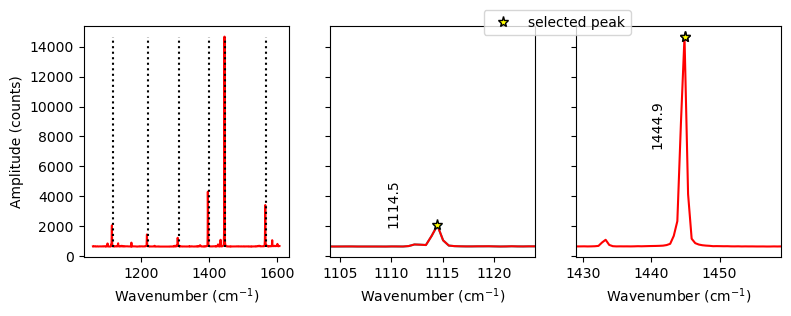

In [10]:
# Specify the approximate peak positions of the lines you are interested in
# If your drift is off the real positions, you'll have to tweak these numbers
peak1_cent=1114 # approximate position of the 1st line you are interested in
peak2_cent=1444 # Approximate position of the 2nd line you are interested in


Ne, df_sort_Ne_trim, nearest_pk1, nearest_pk2=pf.plot_Ne_lines(path=mypath, filename=filename, filetype=filetype, 
n_peaks=6, peak1_cent=peak1_cent, peak2_cent=peak2_cent,
height=10, threshold=0.6, distance=1, prominence=10, width=1, exclude_range_1=None,
exclude_range_2=None)

## You can tweak parameters here
- The default parameters may work, you can see what those are here:
- Most important things, the number of peaks you want for 1117, and the offset for this peak (LH_offset_min) if you are fitting the 1117 line as you need 2 peaks
- By default, the function applies the fit to all the points inside the outermost background positions. This can be trimmed using x_span_pk1_override, and x_span_pk2_override
- See figure from Penny for what these parameters actually are

In [11]:
pf.Ne_peak_config()

Ne_peak_config(N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), x_range_baseline=20, y_range_baseline=200, amplitude=100, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

- You can also overwrite any of these, the most likely things you'll want to overwrite are the background positions, or the amplitude

In [12]:
Ne_Config=pf.Ne_peak_config(amplitude=100, LH_offset_mini=[2, 5], 
lower_bck_pk1=(-50, -30), upper_bck1_pk1=[7, 13], upper_bck2_pk1=[50, 80],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[15, 50], upper_bck2_pk2=[50, 80],
x_range_peak=15, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10])
Ne_Config

Ne_peak_config(N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -30), upper_bck1_pk1=[7, 13], upper_bck2_pk1=[50, 80], lower_bck_pk2=[-40, -30], upper_bck1_pk2=[15, 50], upper_bck2_pk2=[50, 80], x_range_baseline=20, y_range_baseline=200, amplitude=100, x_range_peak=15, x_range_residual=7, LH_offset_mini=[2, 5], x_span_pk1=[-10, 8], x_span_pk2=[-10, 10])

,filename,pk2_peak_cent,error_pk2,pk1_peak_cent,error_pk1,deltaNe,Ne_Corr,Ne_Corr_min,Ne_Corr_max,residual_pk2,residual_pk1
0,000_Ne_1.csv,1444.727098,0.00349,1114.388987,NaN,330.33811,1.000422,NaN,NaN,53.260206,12.700857


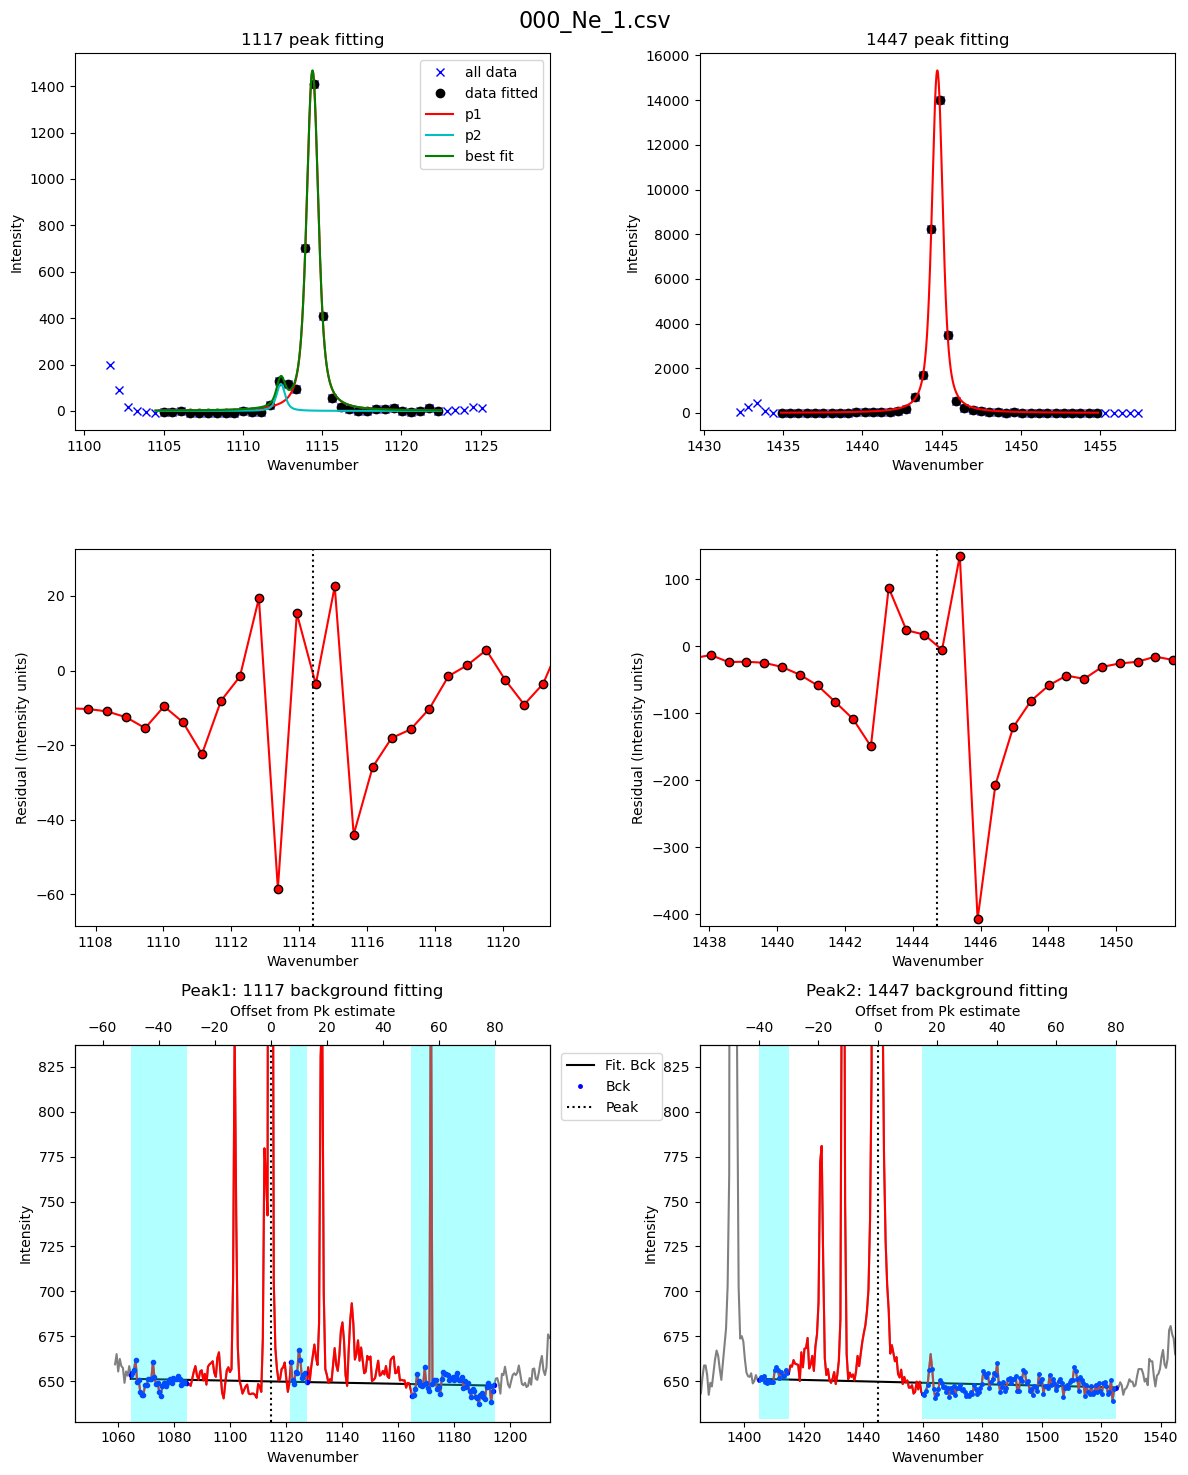

In [13]:
# You also need to set whether you want 1 peak or 2 for the LH diad
peaks_1=2

df_test=pf.fit_Ne_lines(  
    config=Ne_Config, peaks_1=peaks_1,
    Ne=Ne, filename=filename, path=mypath, prefix=prefix,
    Ne_center_1=nearest_pk1, Ne_center_2=nearest_pk2,
    DeltaNe_ideal=ideal_split['Ne_Split'])                                                                 
                                                                     
        
display(df_test)

## Now you can loop over all files using these parameters
- Most important thing you can change is plot_figure=False, much quicker, but wont save or show figures, plot_figure=True will)
- If you need, you can add other parameters in the loop here. 

In [14]:
len(Ne_files)

5

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.36s/it]


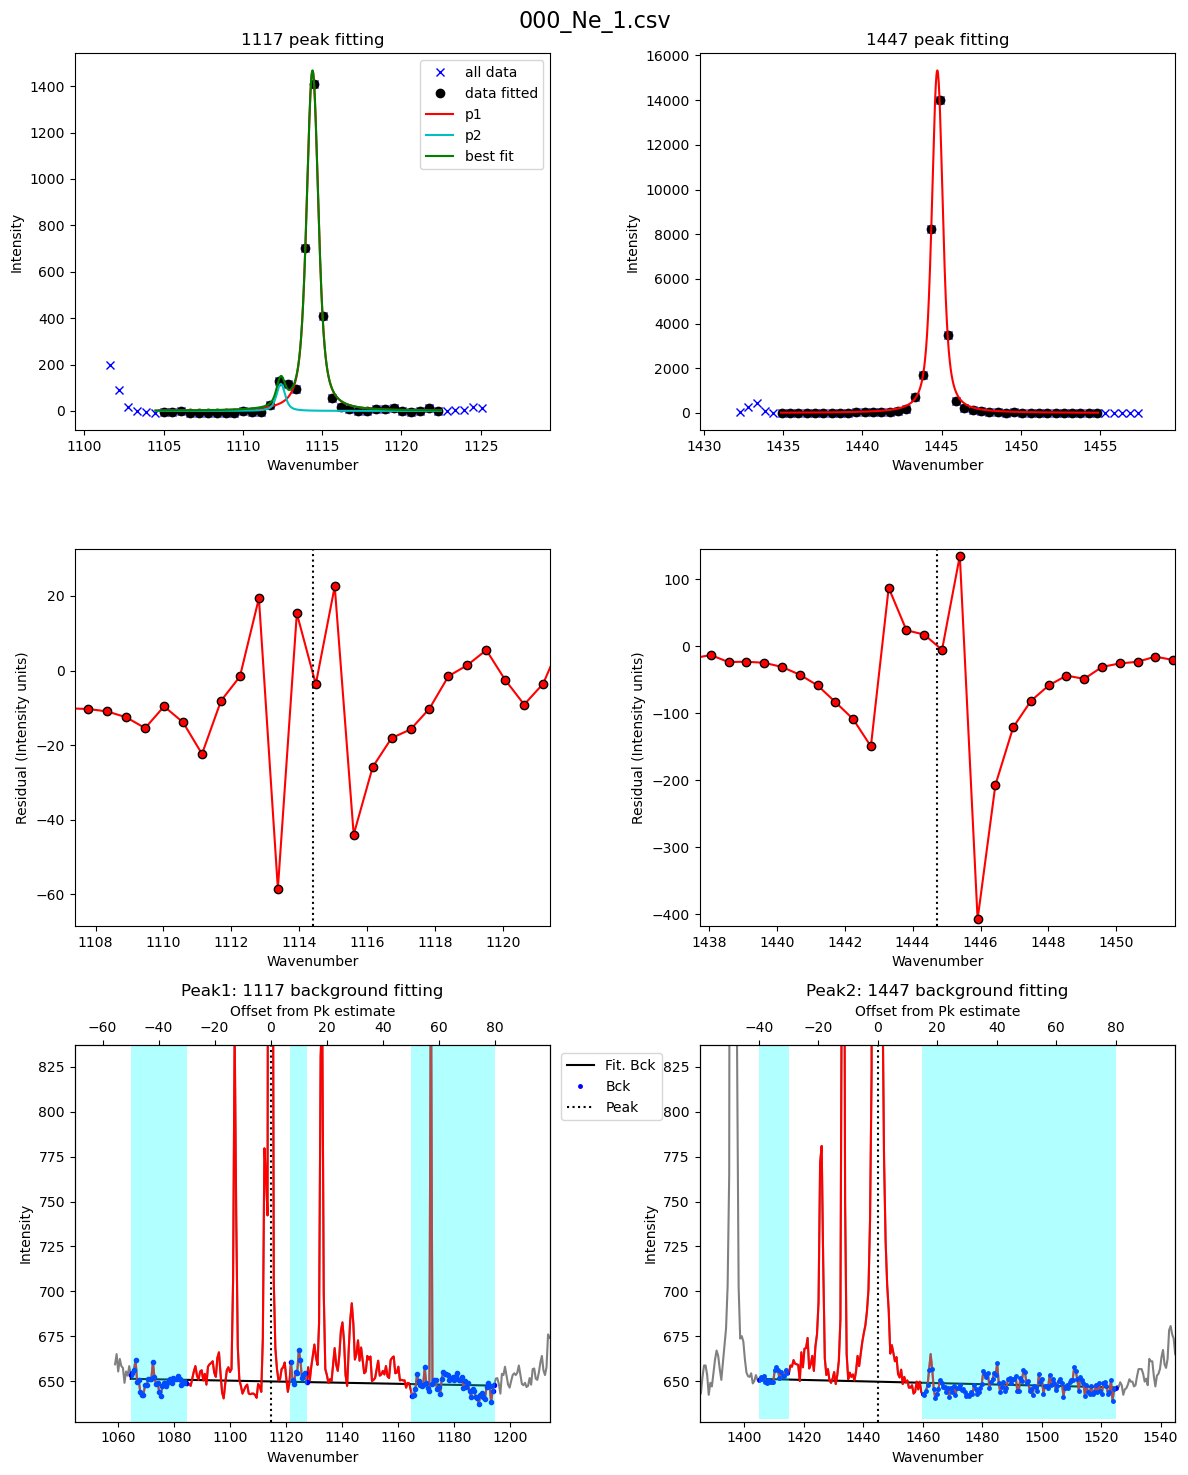

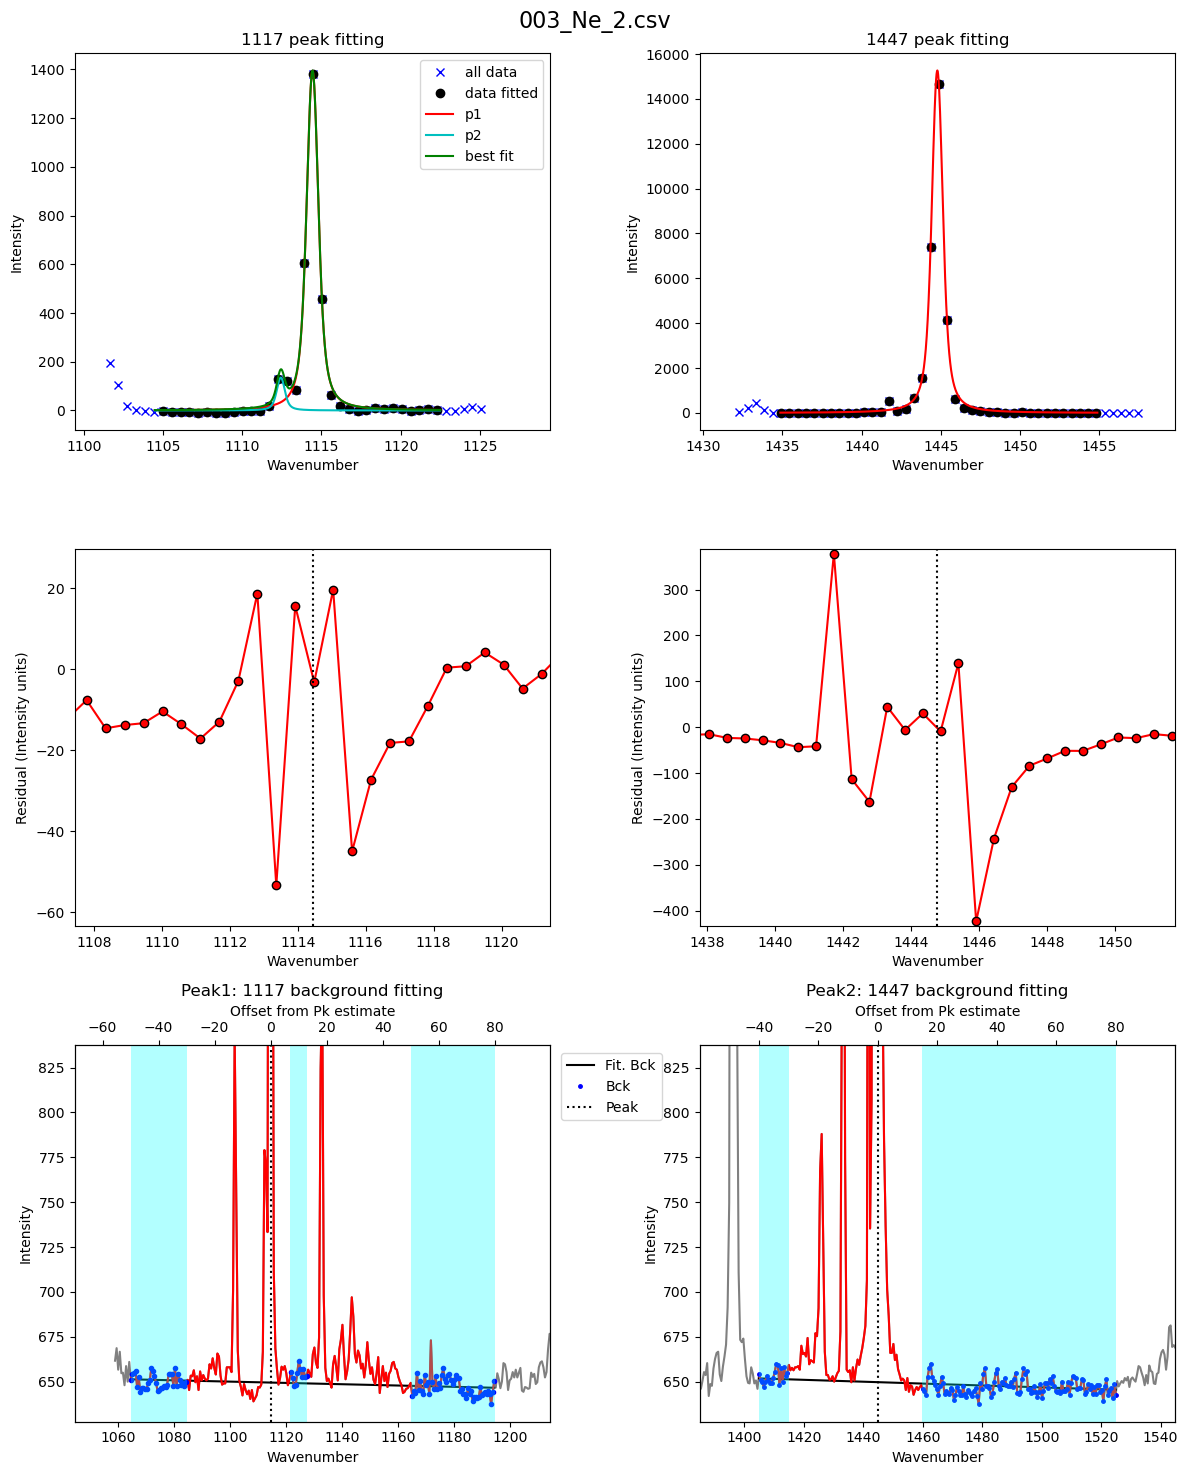

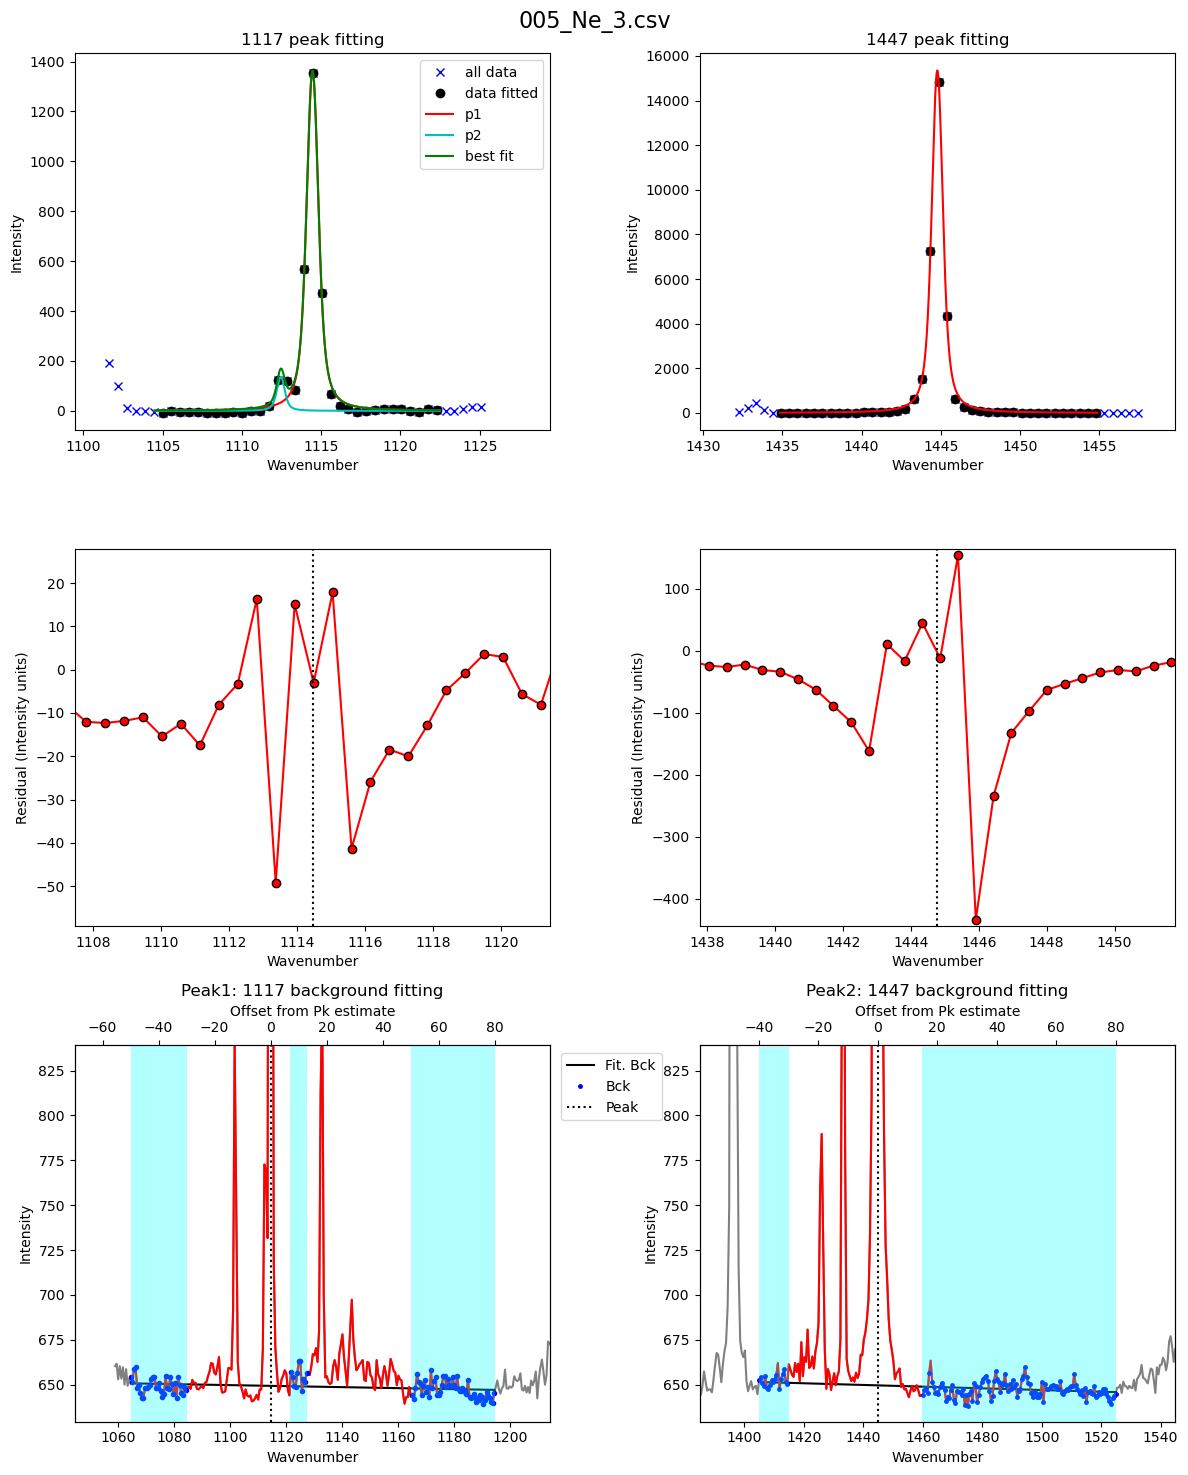

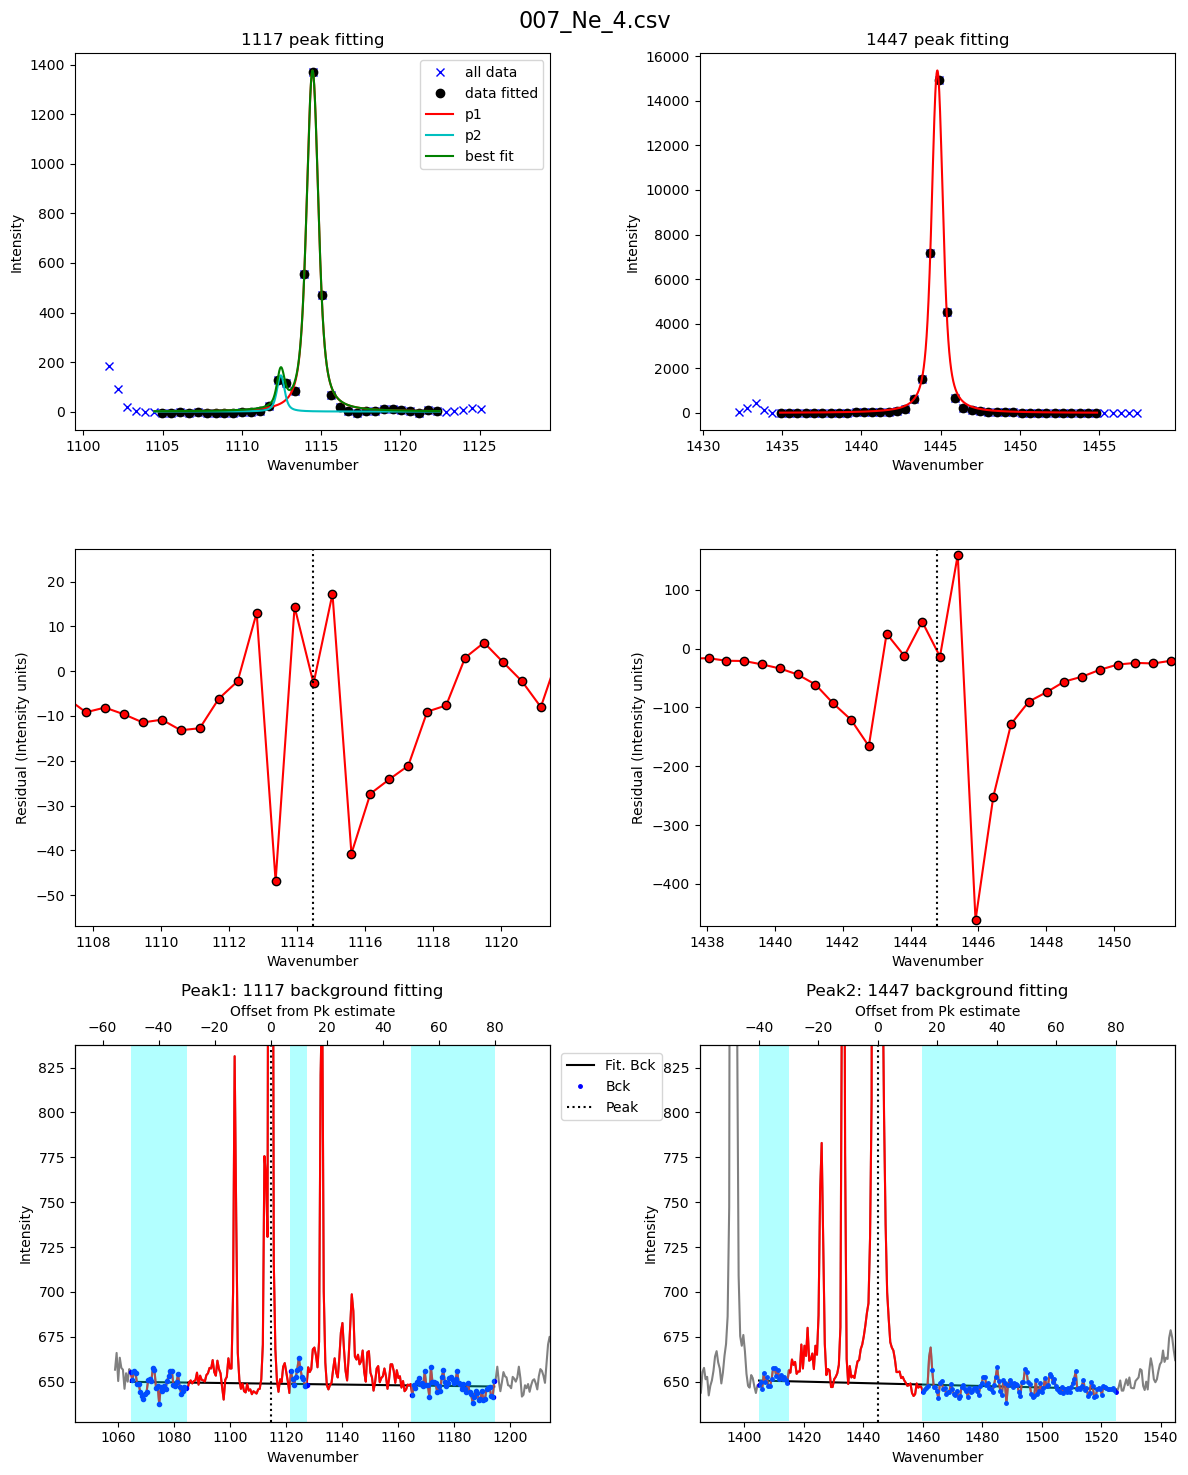

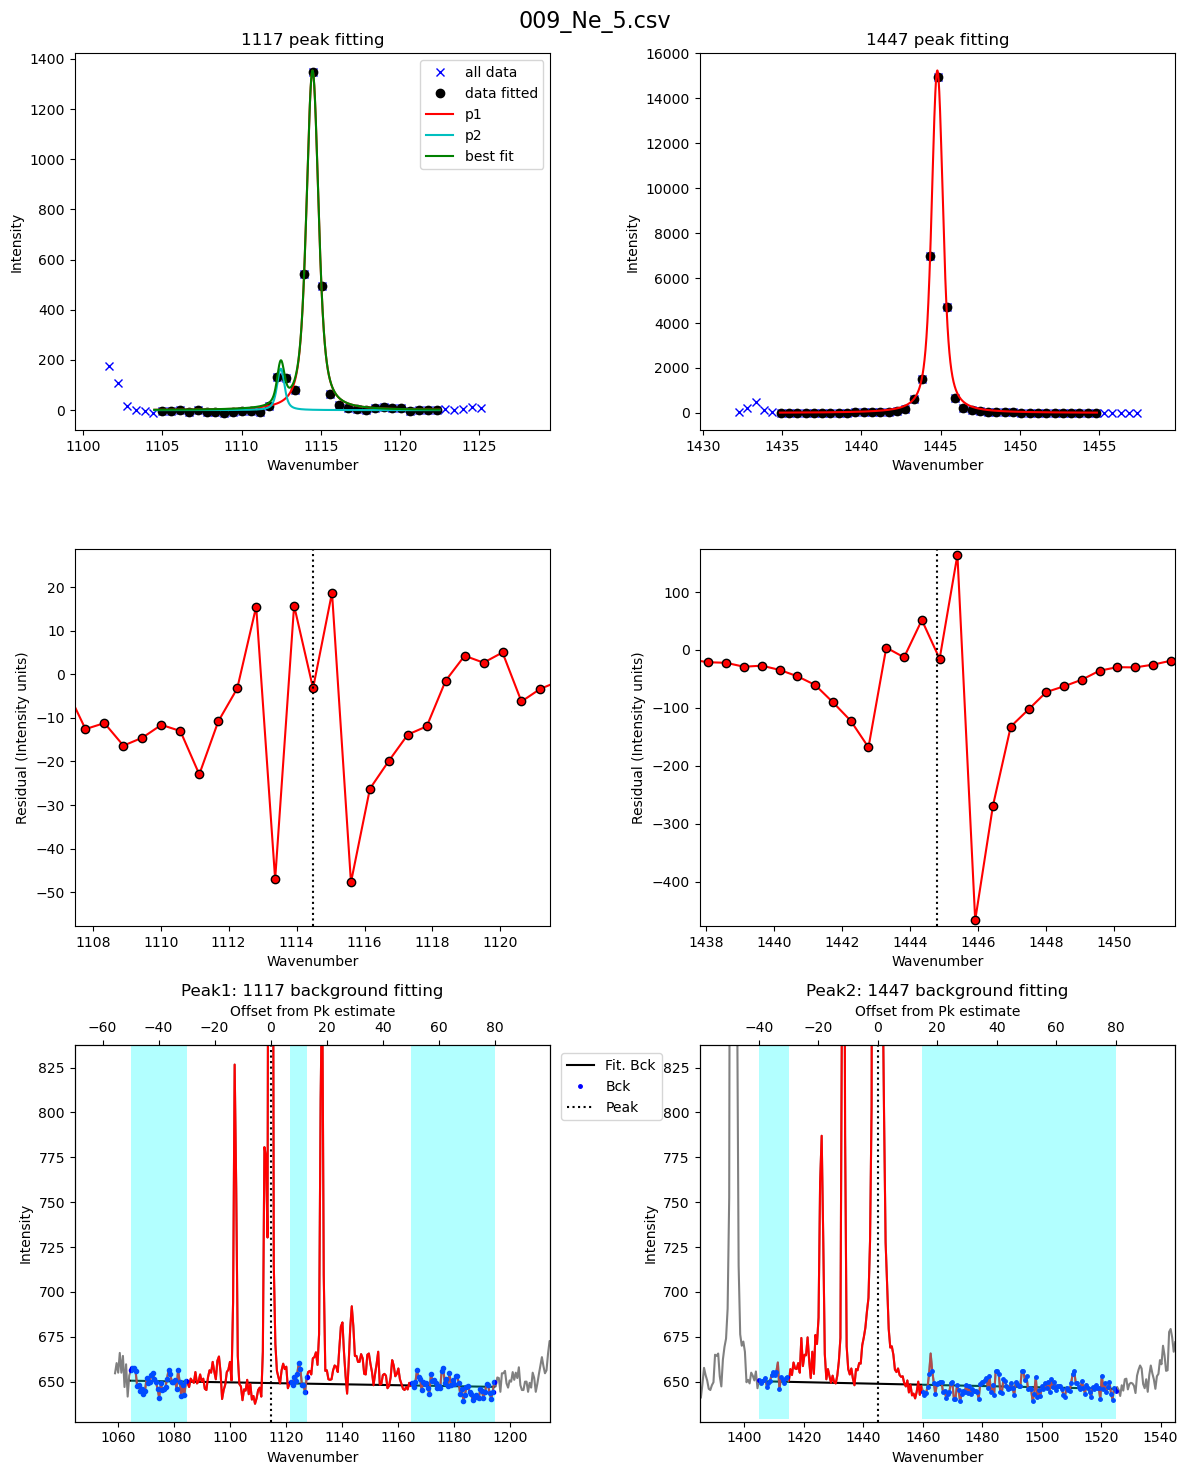

In [15]:
df2=pf.loop_Ne_lines(files=Ne_files, path=mypath, filetype='head_csv',
                  config=Ne_Config, peaks_1=2, Ne=Ne, Ne_center_1=nearest_pk1,
                  Ne_center_2=nearest_pk2, DeltaNe_ideal=ideal_split['Ne_Split'], 
                  plot_figure=True, save_clipboard=True, single_acq=False)

# If any are weird, can fit again here
- If you refit, you'll have to replace the value in the saved dataframe

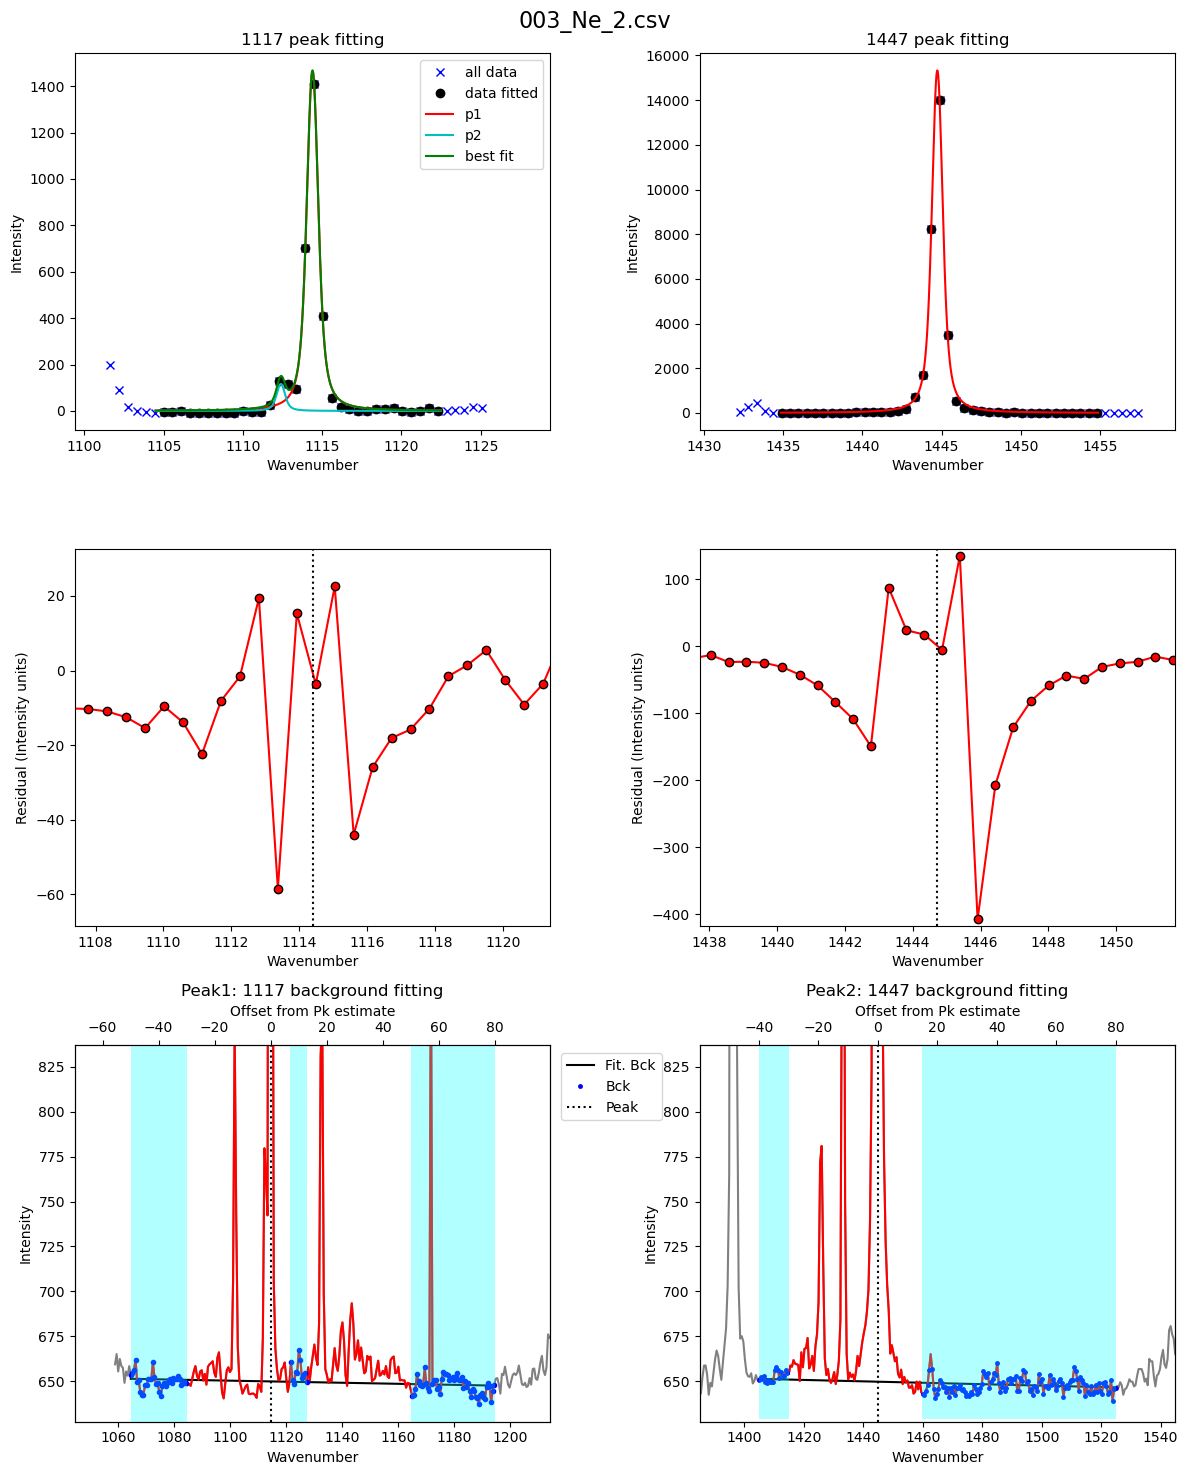

In [16]:
# Which file
filename2=Ne_files[1]  # Or you could put a string here, like 'NE1.txt' 

# Tweak fit

Ne_Config2=pf.Ne_peak_config(amplitude=100, LH_offset_mini=[2, 5], 
lower_bck_pk1=(-50, -30), upper_bck1_pk1=[7, 13], upper_bck2_pk1=[50, 80],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[15, 50], upper_bck2_pk2=[50, 80],
x_range_peak=15, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10])
Ne_Config

# You also need to set whether you want 1 peak or 2 for the LH diad
peaks_1=2

df_test=pf.fit_Ne_lines(  
    config=Ne_Config2, peaks_1=peaks_1,
    Ne=Ne, filename=filename2, path=mypath, prefix=prefix,
    Ne_center_1=nearest_pk1, Ne_center_2=nearest_pk2,
    DeltaNe_ideal=ideal_split['Ne_Split'])                                                                 
                                                                     
        
#config: Ne_peak_config=Ne_peak_config(),

## Stitching meta data with Ne line data

In [17]:
# See what deliminators you have in your metadata file you have just got
print(meta['filename'][0])

000_Ne_1--Information.txt


In [18]:
# remove these to get the pure file name you can compare 
file_m=pf.extracting_filenames_generic(names=meta['filename'],
    prefix=True, str_prefix='_',
    suffix=True, str_suffix='--',
   file_type='.txt')

file_m

array(['Ne_1', 'Ne_2', 'Ne_3', 'Ne_4', 'Ne_5'], dtype=object)

In [19]:
# See what file names you have for your actual datafiles
print(df2['filename'][0])

000_Ne_1.csv


In [20]:
# Remove these to get the pure file name
file_s=pf.extracting_filenames_generic(names=df2['filename'],
    prefix=True, str_prefix='_',
   file_type='.csv')
file_s

array(['Ne_1', 'Ne_2', 'Ne_3', 'Ne_4', 'Ne_5'], dtype=object)

## Now combining them

In [21]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now lets inspect what our Ne correction factors actually look like

In [22]:
help(pf.plot_Ne_corrections)

Help on function plot_Ne_corrections in module DiadFit.ne_lines:

plot_Ne_corrections(df=None, x_axis=None, x_label='index', marker='o', mec='k', mfc='r')
    ## Plot to help inspect which Ne lines to discard



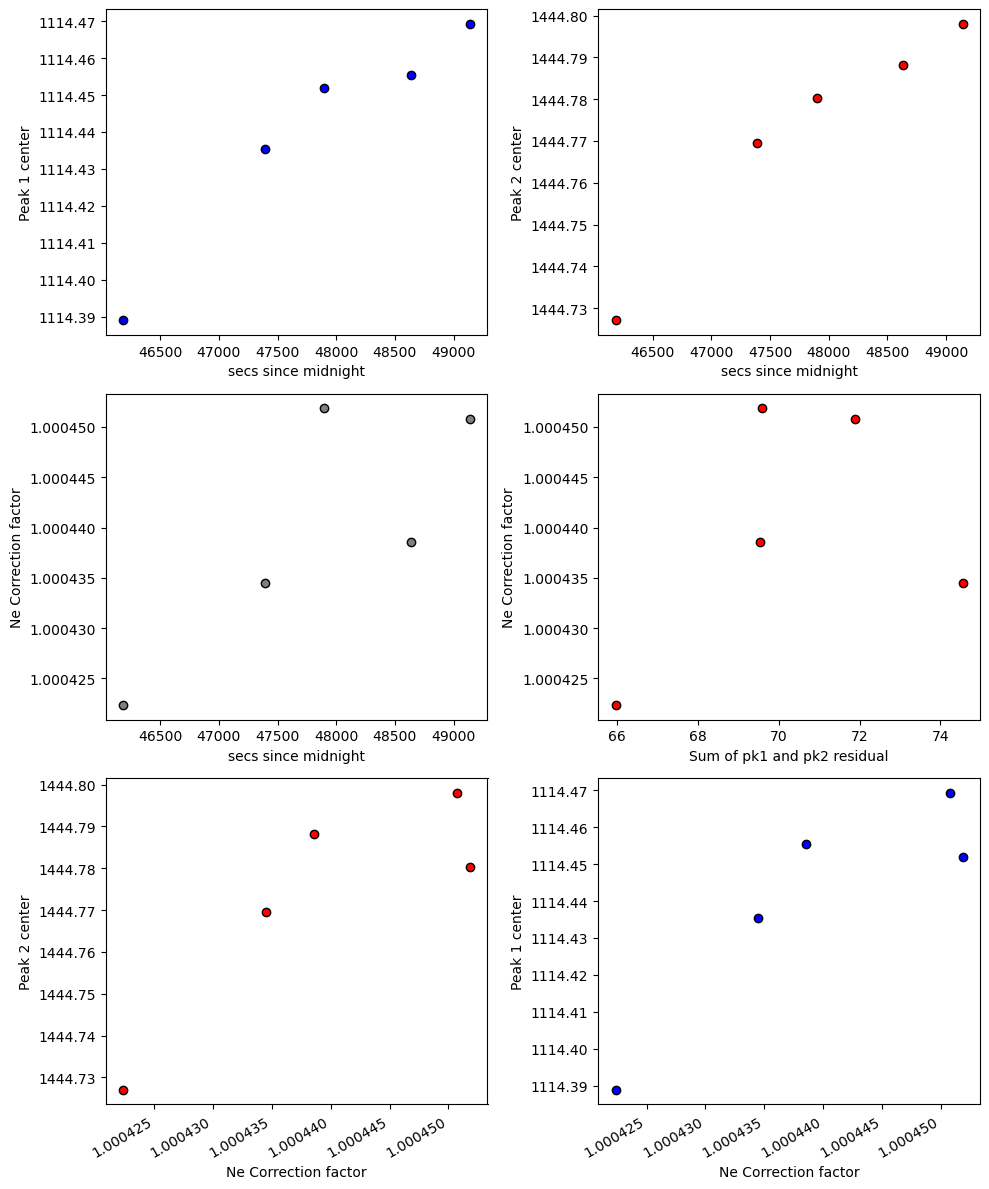

In [23]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')

In [5]:
df2

NameError: name 'df2' is not defined

## Now lets make a regression against time

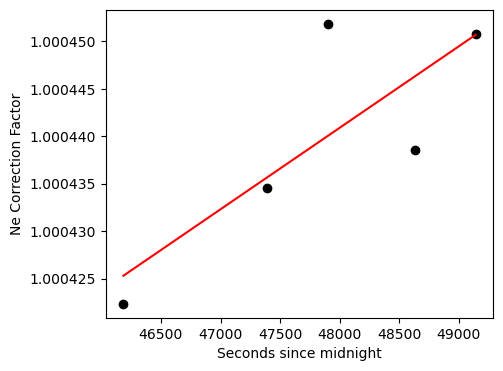

In [23]:
model=pf.reg_Ne_lines_time(df=df_combo, N_poly=1, fit='poly')

## SAving as pickle, can then load as a pickle

In [24]:
import pickle
with open('Ne_Line_Regression_ExampleBlack.pck', 'wb') as file_handle:
    pickle.dump(model, file_handle)

In [25]:
with open('Ne_Line_Regression_ExampleBlack.pck', 'rb') as file_handle:
    my_loaded_model = pickle.load(file_handle)

## You can then load these pickles into the notebook where you fit your Diad data|